# Analysis for the kinematics 

*(Stanford course ME303, Win 2017)*

* The videos were taken by Lentink lab's Phantom LC310 and Sony RX10 III high-speed cameras.
* Video digitization was done by the MATLAB DigitizingTools developed by the [Hedrick Lab](http://www.unc.edu/~thedrick/software1.html) at UNC 

---

In [2]:
## prep
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation as animation
%matplotlib inline

## <font color="blue">Examine the Video Frames</font>
Check the convention of indexing in `imageio` and the tracking points `csv` files.

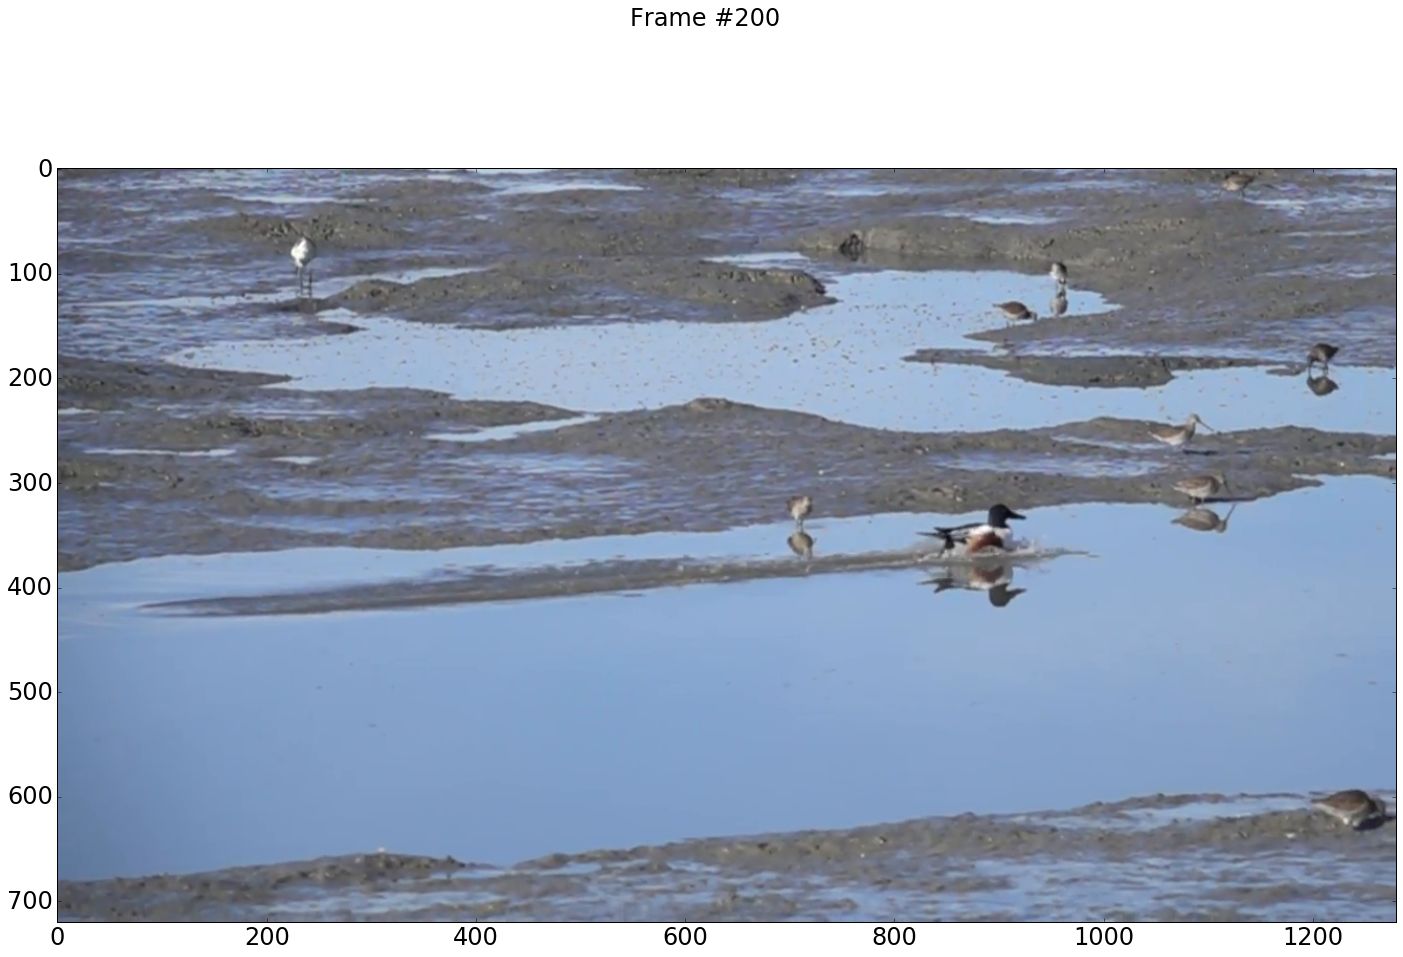

In [3]:
## The #200 frame in the trimmed and cropped avocet video
file_avo = './videos/avocet.mp4'
file_sho = './videos/shoveler.mp4'

vid_sho  = imageio.get_reader(file_sho,  'ffmpeg')
vid_avo  = imageio.get_reader(file_avo,  'ffmpeg')
nums = [10, 20, 100,200,400]

num = 200 # frame number
image = vid_sho.get_data(num)
fig, ax = plt.subplots(figsize=(24,16))
fig.suptitle('Frame #{}'.format(num), fontsize=24)
plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.imshow(image)

In [4]:
## digitized points data
trk_avo = pd.read_csv('./tracking/avocet_xypts.csv')
trk_sho = pd.read_csv('./tracking/gliding_xypts.csv')

In [5]:
trk_sho.head(111)[101:]

,pt1_cam1_X,pt1_cam1_Y,pt2_cam1_X,pt2_cam1_Y,pt3_cam1_X,pt3_cam1_Y,pt4_cam1_X,pt4_cam1_Y,pt5_cam1_X,pt5_cam1_Y,pt6_cam1_X,pt6_cam1_Y,pt7_cam1_X,pt7_cam1_Y
101,501.615670,266.714640,592.97,275.88,575.413985,233.915389,576.438962,258.514828,521.270000,244.980000,500.770000,264.360000,586.12,393.40
102,504.690600,265.689664,599.04,277.82,581.563845,234.940366,581.563845,259.539804,526.060000,245.790000,503.665623,267.739617,586.65,394.62
103,507.765529,263.639711,604.97,279.33,585.663752,238.015295,585.663752,260.564781,531.290000,246.950000,513.915389,272.864500,587.12,396.37
104,516.990319,260.564781,610.98,280.59,588.738681,239.040272,591.813611,262.614734,537.320000,247.420000,522.115202,273.889477,587.56,397.42
105,521.090225,262.614734,616.87,282.60,592.838588,241.090225,598.988447,265.689664,542.800000,247.950000,539.539804,279.014360,588.03,398.46
106,528.265062,262.614734,622.60,284.15,603.088354,243.140179,605.138307,265.689664,547.250000,250.310000,548.764594,283.114266,586.90,399.58
107,532.364968,265.689664,628.39,285.46,604.113330,246.215108,610.263190,269.789570,554.914453,247.240085,556.964407,285.164219,586.58,401.31
108,538.514828,268.764594,633.84,286.45,610.263190,247.240085,616.413050,269.789570,560.039336,249.290038,563.114266,285.164219,586.35,402.30
109,543.639711,271.839524,639.20,287.81,615.810000,248.920000,621.537933,270.814547,565.164219,251.339991,567.214173,287.214173,587.55,403.96
110,551.839524,274.914453,644.76,289.81,621.480000,250.580000,628.712769,272.864500,571.314079,253.389945,571.870000,288.410000,588.05,405.23


Looks like the indexing systems are opposite in the y direction...
<br>
Let's correct for that:

In [6]:
## dimensions; the 3rd dimension represents RGB colors
print vid_avo.get_data(0).shape
print vid_sho.get_data(0).shape

(720, 1280, 3)
(720, 1280, 3)


In [7]:
## "flip" the y axis
sho_y_max = vid_sho.get_data(0).shape[0]
avo_y_max = vid_avo.get_data(0).shape[0]

for column in range(trk_sho.shape[1]):
    if column%2:
        trk_sho.iloc[:,column] = sho_y_max - trk_sho.iloc[:,column]
for column in range(trk_avo.shape[1]):
    if column%2:
        trk_avo.iloc[:,column] = avo_y_max - trk_avo.iloc[:,column]   

---
## <font color="blue">Definitions</font>
Some information for calibration

### <font color="green">Projection</font>
*(Body length / wing span reference: Sibley's Field Guide)*
<br><br>
Overall, assume **no projection in the vertical direction**. Namely we are viewing the birds on the same horizontal.
<br><br>
To calibrate length scales, a nearby bird with known body length serves as a reference, as long as it lies in parallel to the x-axis. I may or may not take into account the motion angle projection in the analysis below.
<br><br>
<p style="text-indent: 10px"><font color="brown">Avocet</font>
    <img src="./imgs/avo_proj_len_300x200.png" width=50%><br>
<p style="text-indent: 30px"> motion angle $\approx 45^\circ$; 1 pixel $\approx$ 0.5 cm

<p style="text-indent: 10px"><font color="brown">Shoveler</font>
<img src="./imgs/sho_proj_len_1200x300.png" width=80%><br>
<p style="text-indent: 30px"> motion angle $\approx 30^\circ$; 1 pixel $\approx$ 0.8 cm

### <font color="green">Frame Rate</font>
* <p style="text-indent: 10px"><font color="brown">Avocet</font>: 
  <p style="text-indent: 30px">Frame rate = 500 fps (original) / 30 fps in slow motion => **1 frame = 1/500 s** 
* <p style="text-indent: 10px"><font color="brown">Shoveler</font>:
  <p style="text-indent: 30px">Frame rate = 480 fps (original) / 30 fps in slow motion => **1 frame = 1/240 s**
  <p style="text-indent: 30px">*(note: here I assume half of the frames were lost since there are only 480 frames in total instead of the expected 960 frames for 2 seconds)*

---
## <font color="blue">Definitions and Approximations</font>

### <font color="green">Point Numbering</font>
|       |      Avocet      |   Shoveler       | color       |  (comments) |
|-------|------------------|------------------|-------------|-------------|
|    1  |   Right Wingtip  |   Right Wingtip  | <font color="red">red</font> |       -     |
|    2  |   Eye (right)    |   Beak tip       | <font color="blue">blue</font> |       -     |
|    3  |   Foot Toes      |   Foot Toes      | <font color="green">green</font> |       -     |
|    4  |   Neck base      |   Neck base      | <font color="yellow">yellow</font> | nearest to the torso; the "body" |
|    5  |   Tail base      |   Tail tip       | <font color="cyan">cyan</font> |       -     |
|    6  |   Left Wingtip   |   Left Wingtip   | <font color="magenta">purple</font> |       -     |
|    7  |      -           |   Reference      | white | measures the motion of the camera |
<br><br>
<img src="./imgs/shoveler_pts.png" width=80%><br>

### <font color="green">Assumptions</font>
* <p style="text-indent: 10px"><font color="brown">Wing</font>: 
  <p style="text-indent: 30px"> For simplicity, I'll first approximate each wing as a sinusoidally oscillating rod 
  (i.e. no morphing). 
  <p style="text-indent: 30px"> The amplitude is determined fully by the y-direction motion, and so on.
  
* <p style="text-indent: 10px"><font color="brown">Torso Rotation</font>: 
  <p style="text-indent: 30px"> The straight line connecting Point #4 and #5 (neck to tail bases) determines the rotation angle of the body.
  <p style="text-indent: 30px"> Rotations are assumed to be moving about the center of gravity. 
  <p style="text-indent: 30px"> For example, the avocets exhibit primarily 'pitch' rotation, therefore utilizing $I_\text{pitch}$ in dynamics.

---
### <font color="red">Codes</font>

In [8]:
from __future__ import division
from scipy.interpolate import splrep, splev

class Kinematics(object):
    """
    Class computing and displaying the position/velocity/acceleration of motions of interest.
    """
    
    def __init__(self,vid_avo,vid_sho,avo_proj,sho_proj,
                 avo_pixl,sho_pixl,avo_fras,sho_fras,
                 avo_data,sho_data):
        ## videos
        self.avo_vid = vid_avo
        self.sho_vid = vid_sho
        
        ## parameters
        self.avo_proj = avo_proj # projection angle
        self.sho_proj = sho_proj
        self.avo_pixl = avo_pixl # pixelwise physical length
        self.sho_pixl = sho_pixl
        self.avo_fras = avo_fras # framewise physical time
        self.sho_fras = sho_fras
        
        ## tracking data
        self.avo_data = avo_data
        self.sho_data = sho_data
        
        ### color coding for plotting uses
        self.clrs = ['r','b','g','y','c','m','w']
        
    def disp_traj(self, showvid=True, option=1):
        """
        Animated trajectories overlayying (optional) on the videos.
        
         showvid == True will show the video; otherwise only points 
         
         option 1 = avocet
         option 2 = shoveler
        """
        
        ## which video
        if option == 1:
            vid = self.avo_vid
            xxxxs = [self.avo_data['pt1_cam1_X'], self.avo_data['pt2_cam1_X'],
                     self.avo_data['pt3_cam1_X'], self.avo_data['pt4_cam1_X'],
                     self.avo_data['pt5_cam1_X'], self.avo_data['pt6_cam1_X'], 
                     np.empty(vid.get_length())*np.nan]
            liney = [self.avo_data['pt1_cam1_Y'], self.avo_data['pt2_cam1_Y'],
                     self.avo_data['pt3_cam1_Y'], self.avo_data['pt4_cam1_Y'],
                     self.avo_data['pt5_cam1_Y'], self.avo_data['pt6_cam1_Y'], 
                     np.empty(vid.get_length())*np.nan]
        else:
            vid = self.sho_vid
            xxxxs = [self.sho_data['pt1_cam1_X'], self.sho_data['pt2_cam1_X'],
                     self.sho_data['pt3_cam1_X'], self.sho_data['pt4_cam1_X'],
                     self.sho_data['pt5_cam1_X'], self.sho_data['pt6_cam1_X'], 
                     self.sho_data['pt7_cam1_X']]
            liney = [self.sho_data['pt1_cam1_Y'], self.sho_data['pt2_cam1_Y'],
                     self.sho_data['pt3_cam1_Y'], self.sho_data['pt4_cam1_Y'],
                     self.sho_data['pt5_cam1_Y'], self.sho_data['pt6_cam1_Y'], 
                     self.sho_data['pt7_cam1_Y']]
        clrs = self.clrs
        
        ##
        totalframes = vid.get_length()
        
        fig = plt.figure(figsize=(24,16))
        ax  = plt.axes(xlim=(0, vid.get_data(0).shape[1]), ylim=(vid.get_data(0).shape[0],0))
        
        lines = sum([ax.plot([], [], '-', c=c, lw=10) for c in clrs], [])
        
        def init():
            for line in lines:
                line.set_data([], [])
            return lines
        
        def animate(i):
            # video
            if showvid:
                image = vid.get_data(i)
                ax.imshow(image)
            
            j = 0
            for line in lines:
                line.set_data(xxxxs[j][:i],liney[j][:i])
                j += 1
            return lines
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=totalframes, repeat=False)
        return ani
        
    def traj_png(self, option=1):
        """
        Since the "disp_traj" method is too slow, 
        each frame is saved as a png image in this method.
        
        Additional features (compared to "disp_traj") are
        - figure title
        - 
        """
        
        ## which video
        if option == 1:
            vid   = self.avo_vid
            time  = self.avo_fras
            name  = 'Avo'
            xxxxs = [self.avo_data['pt1_cam1_X'], self.avo_data['pt2_cam1_X'],
                     self.avo_data['pt3_cam1_X'], self.avo_data['pt4_cam1_X'],
                     self.avo_data['pt5_cam1_X'], self.avo_data['pt6_cam1_X'], 
                     np.empty(vid.get_length())*np.nan]
            liney = [self.avo_data['pt1_cam1_Y'], self.avo_data['pt2_cam1_Y'],
                     self.avo_data['pt3_cam1_Y'], self.avo_data['pt4_cam1_Y'],
                     self.avo_data['pt5_cam1_Y'], self.avo_data['pt6_cam1_Y'], 
                     np.empty(vid.get_length())*np.nan]
        else:
            vid   = self.sho_vid
            time  = self.sho_fras
            name  = 'Sho'
            xxxxs = [self.sho_data['pt1_cam1_X'], self.sho_data['pt2_cam1_X'],
                     self.sho_data['pt3_cam1_X'], self.sho_data['pt4_cam1_X'],
                     self.sho_data['pt5_cam1_X'], self.sho_data['pt6_cam1_X'], 
                     self.sho_data['pt7_cam1_X']]
            liney = [self.sho_data['pt1_cam1_Y'], self.sho_data['pt2_cam1_Y'],
                     self.sho_data['pt3_cam1_Y'], self.sho_data['pt4_cam1_Y'],
                     self.sho_data['pt5_cam1_Y'], self.sho_data['pt6_cam1_Y'], 
                     self.sho_data['pt7_cam1_Y']]
        clrs  = self.clrs
        label = ['RW','Head','Toe','Neck (base)','Tail (base)','LW','Ref.']
        
        ## dimensions
        xlim = vid.get_data(0).shape[1]
        ylim = vid.get_data(0).shape[0]
        
        ## loop through frames
        for frame in range(vid.get_length()):
            plt.figure(figsize=(24,16))
            
            ## video frame
            image = vid.get_data(frame)
            plt.imshow(image)
            
            ## trajectories
            for j in range(len(liney)):
                plt.plot(xxxxs[j][:frame],liney[j][:frame],c=clrs[j],lw=8,label=label[j])
                
            plt.title('Time: %.3f s' %(time*frame), fontsize=32)
            plt.xlim(0,xlim); plt.ylim(ylim,0)
            plt.legend(loc='upper right', fontsize=24)

            plt.savefig('./%s_traj/frame_%03d.png' %(name,frame))
            plt.close() # prevent displaying inline
        
    def vel_acc(self):
        """
        Compute the velocity and acceleration profiles
        """
        ### read in and correct for 'global' motions (camera)
        ## camera
        sho_cax,sho_cay = self.sho_data['pt7_cam1_X'],self.sho_data['pt7_cam1_Y']
        
        ## wing tips
        avo_rwx,avo_rwy = self.avo_data['pt1_cam1_X'],self.avo_data['pt1_cam1_Y']
        sho_rwx,sho_rwy = self.sho_data['pt1_cam1_X']-sho_cax,self.sho_data['pt1_cam1_Y']-sho_cay
        avo_lwx,avo_lwy = self.avo_data['pt6_cam1_X'],self.avo_data['pt6_cam1_Y']
        sho_lwx,sho_lwy = self.sho_data['pt6_cam1_X']-sho_cax,self.sho_data['pt6_cam1_Y']-sho_cay
        
        ## head (beak or eye)
        avo_hdx,avo_hdy = self.avo_data['pt2_cam1_X'],self.avo_data['pt2_cam1_Y']
        sho_hdx,sho_hdy = self.sho_data['pt2_cam1_X']-sho_cax,self.sho_data['pt2_cam1_Y']-sho_cay
        
        ## toe
        avo_tox,avo_toy = self.avo_data['pt3_cam1_X'],self.avo_data['pt3_cam1_Y']
        sho_tox,sho_toy = self.sho_data['pt3_cam1_X']-sho_cax,self.sho_data['pt3_cam1_Y']-sho_cay
        
        ## body (neck and tail bases)
        avo_nex,avo_ney = self.avo_data['pt4_cam1_X'],self.avo_data['pt4_cam1_Y']
        sho_nex,sho_ney = self.sho_data['pt4_cam1_X']-sho_cax,self.sho_data['pt4_cam1_Y']-sho_cay
        avo_tax,avo_tay = self.avo_data['pt5_cam1_X'],self.avo_data['pt5_cam1_Y']
        sho_tax,sho_tay = self.sho_data['pt5_cam1_X']-sho_cax,self.sho_data['pt5_cam1_Y']-sho_cay
        
        ## - wrap up and calibrate for physical sizes
        avo_x = [avo_rwx*self.avo_pixl,avo_hdx*self.avo_pixl,avo_tox*self.avo_pixl, \
                 avo_nex*self.avo_pixl,avo_tax*self.avo_pixl,avo_lwx*self.avo_pixl]
        avo_y = [avo_rwy*self.avo_pixl,avo_hdy*self.avo_pixl,avo_toy*self.avo_pixl, \
                 avo_ney*self.avo_pixl,avo_tay*self.avo_pixl,avo_lwy*self.avo_pixl]
        sho_x = [sho_rwx*self.sho_pixl,sho_hdx*self.sho_pixl,sho_tox*self.sho_pixl, \
                 sho_nex*self.sho_pixl,sho_tax*self.sho_pixl,sho_lwx*self.sho_pixl]
        sho_y = [sho_rwy*self.sho_pixl,sho_hdy*self.sho_pixl,sho_toy*self.sho_pixl, \
                 sho_ney*self.sho_pixl,sho_tay*self.sho_pixl,sho_lwy*self.sho_pixl]
        
        ### time stamp correction
        avo_time = np.linspace(0.,len(avo_rwx)*self.avo_fras,len(avo_rwx))
        sho_time = np.linspace(0.,len(sho_rwx)*self.sho_fras,len(sho_rwx))
        
        ### submethods to fit spline curves
        def _spl_fit(t,x,y,k,sl,sm):
            rwx,hdx,tox,nex,tax,lwx = x
            rwy,hdy,toy,ney,tay,lwy = y
            
            rwx,hdx,tox,nex,tax,lwx = np.array(rwx),np.array(hdx),np.array(tox),np.array(nex),np.array(tax),np.array(lwx)
            rwy,hdy,toy,ney,tay,lwy = np.array(rwy),np.array(hdy),np.array(toy),np.array(ney),np.array(tay),np.array(lwy)
            
            ## subtract "body" motion (neck)
            taxx,tayy = tax,tay # for rotation purposes
            rwx,hdx,tox,tax,lwx = rwx-nex,hdx-nex,tox-nex,tax-nex,lwx-nex
            rwy,hdy,toy,tay,lwy = rwy-ney,hdy-ney,toy-ney,tay-ney,lwy-ney
            
            ## fit splines
            rwx_f,rwy_f = splrep(t,np.nan_to_num(rwx),k=k,s=sl), splrep(t,np.nan_to_num(rwy),k=k,s=sl)
            hdx_f,hdy_f = splrep(t,np.nan_to_num(hdx),k=k,s=sm), splrep(t,np.nan_to_num(hdy),k=k,s=sm)
            tox_f,toy_f = splrep(t,np.nan_to_num(tox),k=k,s=sl), splrep(t,np.nan_to_num(toy),k=k,s=sl)
            nex_f,ney_f = splrep(t,np.nan_to_num(nex),k=k,s=sl), splrep(t,np.nan_to_num(ney),k=k,s=sl)
            tax_f,tay_f = splrep(t,np.nan_to_num(tax),k=k,s=sm), splrep(t,np.nan_to_num(tay),k=k,s=sm)
            lwx_f,lwy_f = splrep(t,np.nan_to_num(lwx),k=k,s=sl), splrep(t,np.nan_to_num(lwy),k=k,s=sl)
        
            ## plot only where data is not nan
            ## - note: x and y are the same
            rw_ix = np.argwhere(~np.isnan(rwx))
            hd_ix = np.argwhere(~np.isnan(hdx))
            to_ix = np.argwhere(~np.isnan(tox))
            ne_ix = np.argwhere(~np.isnan(nex))
            ta_ix = np.argwhere(~np.isnan(tax))
            lw_ix = np.argwhere(~np.isnan(lwx))
            
            ## arrays for plotting purposes: 0th, 1st and 2nd derivatives
            ## - times and original positions
            tt = [t[rw_ix],t[hd_ix],t[to_ix],t[ne_ix],t[ta_ix],t[lw_ix]]
            xx = [rwx[rw_ix],hdx[hd_ix],tox[to_ix],nex[ne_ix],tax[ta_ix],lwx[lw_ix]]
            yy = [rwy[rw_ix],hdy[hd_ix],toy[to_ix],ney[ne_ix],tay[ta_ix],lwy[lw_ix]]
            
            ## - positions
            rwpx_f,rwpy_f = splev(t,rwx_f)[rw_ix],splev(t,rwy_f)[rw_ix]
            hdpx_f,hdpy_f = splev(t,hdx_f)[hd_ix],splev(t,hdy_f)[hd_ix]
            topx_f,topy_f = splev(t,tox_f)[to_ix],splev(t,toy_f)[to_ix]
            nepx_f,nepy_f = splev(t,nex_f)[ne_ix],splev(t,ney_f)[ne_ix]
            tapx_f,tapy_f = splev(t,tax_f)[ta_ix],splev(t,tay_f)[ta_ix]
            lwpx_f,lwpy_f = splev(t,lwx_f)[lw_ix],splev(t,lwy_f)[lw_ix]
            
            px = [rwpx_f,hdpx_f,topx_f,nepx_f,tapx_f,lwpx_f]
            py = [rwpy_f,hdpy_f,topy_f,nepy_f,tapy_f,lwpy_f]
            
            ## - velocities
            rwvx_f,rwvy_f = splev(t,rwx_f,der=1)[rw_ix],splev(t,rwy_f,der=1)[rw_ix]
            hdvx_f,hdvy_f = splev(t,hdx_f,der=1)[hd_ix],splev(t,hdy_f,der=1)[hd_ix]
            tovx_f,tovy_f = splev(t,tox_f,der=1)[to_ix],splev(t,toy_f,der=1)[to_ix]
            nevx_f,nevy_f = splev(t,nex_f,der=1)[ne_ix],splev(t,ney_f,der=1)[ne_ix]
            tavx_f,tavy_f = splev(t,tax_f,der=1)[ta_ix],splev(t,tay_f,der=1)[ta_ix]
            lwvx_f,lwvy_f = splev(t,lwx_f,der=1)[lw_ix],splev(t,lwy_f,der=1)[lw_ix]
            
            vx = [rwvx_f,hdvx_f,tovx_f,nevx_f,tavx_f,lwvx_f]
            vy = [rwvy_f,hdvy_f,tovy_f,nevy_f,tavy_f,lwvy_f]
            
            ## - accelerations
            rwax_f,rway_f = splev(t,rwx_f,der=2)[rw_ix],splev(t,rwy_f,der=2)[rw_ix]
            hdax_f,hday_f = splev(t,hdx_f,der=2)[hd_ix],splev(t,hdy_f,der=2)[hd_ix]
            toax_f,toay_f = splev(t,tox_f,der=2)[to_ix],splev(t,toy_f,der=2)[to_ix]
            neax_f,neay_f = splev(t,nex_f,der=2)[ne_ix],splev(t,ney_f,der=2)[ne_ix]
            taax_f,taay_f = splev(t,tax_f,der=2)[ta_ix],splev(t,tay_f,der=2)[ta_ix]
            lwax_f,lway_f = splev(t,lwx_f,der=2)[lw_ix],splev(t,lwy_f,der=2)[lw_ix]
            
            ax = [rwax_f,hdax_f,toax_f,neax_f,taax_f,lwax_f]
            ay = [rway_f,hday_f,toay_f,neay_f,taay_f,lway_f]
            
            ## - rotations
            where = np.argwhere(~np.isnan(nex)&~np.isnan(taxx))
            ro_t = t[where]
            ro_p = np.rad2deg(np.arctan((ney-tayy)/(nex-taxx)))
            
            ro_f = splrep(t,np.nan_to_num(ro_p),k=k,s=4000)
            
            ## -- position
            ro_pf = splev(t,ro_f)[where]
            ## -- velocity
            ro_vf = splev(t,ro_f,der=1)[where]
            ro_af = splev(t,ro_f,der=2)[where]
            
            ro = [ro_t,ro_pf,ro_vf,ro_af]
            
            return tt,xx,yy,px,py,vx,vy,ax,ay,ro
        
        k, sl, sm = 5, 5000, 3000
        avo_tpva = _spl_fit(avo_time,avo_x,avo_y,k=k,sl=sl,sm=sm)
        sho_tpva = _spl_fit(sho_time,sho_x,sho_y,k=k,sl=sl,sm=sm)
        
        return avo_tpva, sho_tpva
        
    def disp_vel_acc(self):
        """
        Display the velocity and acceleration profiles
        """
        ### extract original/fitted data
        avo_tpva, sho_tpva = self.vel_acc()
                
        ### plotting
        def _plot(tpva,n):
            t,x,y,px,py,vx,vy,ax,ay,ro = tpva
            rot,rop,rov,roa = ro
            
            plt.figure(figsize=(24,70))
            ## frame-moving/body-motion (def:neck base) corrected positions
            plt.subplot(421)
            plt.plot(t[0],x[0],'-.',c=self.clrs[0],lw=5); plt.plot(t[0],px[0],c=self.clrs[0],label='RW')
            plt.plot(t[1],x[1],'-.',c=self.clrs[1],lw=5); plt.plot(t[1],px[1],c=self.clrs[1],label='Head')
            plt.plot(t[2],x[2],'-.',c=self.clrs[2],lw=5); plt.plot(t[2],px[2],c=self.clrs[2],label='Toe')
            plt.plot(t[3],x[3],'-.',c=self.clrs[3],lw=5); plt.plot(t[3],px[3],c=self.clrs[3],label='Neck (base)')
            plt.plot(t[4],x[4],'-.',c=self.clrs[4],lw=5); plt.plot(t[4],px[4],c=self.clrs[4],label='Tail (base)')
            plt.plot(t[5],x[5],'-.',c=self.clrs[5],lw=5); plt.plot(t[5],px[5],c=self.clrs[5],label='LW')
            plt.title('X Positions [%s]' %n, fontsize=32); plt.legend(fontsize=20, loc='upper left')
            plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Position (cm)',fontsize=24)
            plt.xticks(fontsize=20), plt.yticks(fontsize=20)
            
            plt.subplot(422)
            plt.plot(t[0],y[0],'-.',c=self.clrs[0],lw=5); plt.plot(t[0],py[0],c=self.clrs[0],label='RW')
            plt.plot(t[1],y[1],'-.',c=self.clrs[1],lw=5); plt.plot(t[1],py[1],c=self.clrs[1],label='Head')
            plt.plot(t[2],y[2],'-.',c=self.clrs[2],lw=5); plt.plot(t[2],py[2],c=self.clrs[2],label='Toe')
            plt.plot(t[3],y[3],'-.',c=self.clrs[3],lw=5); plt.plot(t[3],py[3],c=self.clrs[3],label='Neck (base)')
            plt.plot(t[4],y[4],'-.',c=self.clrs[4],lw=5); plt.plot(t[4],py[4],c=self.clrs[4],label='Tail (base)')
            plt.plot(t[5],y[5],'-.',c=self.clrs[5],lw=5); plt.plot(t[5],py[5],c=self.clrs[5],label='LW')
            plt.title('Y Positions [%s]' %n, fontsize=32); plt.legend(fontsize=20, loc='upper left')
            plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Position (cm)',fontsize=24)
            plt.xticks(fontsize=20), plt.yticks(fontsize=20)
            
            ## velocities
            plt.subplot(423)
            plt.plot(t[0],vx[0],c=self.clrs[0],label='RW')
            plt.plot(t[1],vx[1],c=self.clrs[1],label='Head')
            plt.plot(t[2],vx[2],c=self.clrs[2],label='Toe')
            plt.plot(t[3],vx[3],c=self.clrs[3],label='Neck (base)')
            plt.plot(t[4],vx[4],c=self.clrs[4],label='Tail (base)')
            plt.plot(t[5],vx[5],c=self.clrs[5],label='LW')
            plt.title('X Velocities [%s]' %n, fontsize=32); plt.legend(fontsize=20, loc='upper left')
            plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Velocity (cm/s)',fontsize=24)
            plt.xticks(fontsize=20), plt.yticks(fontsize=20); plt.ylim(-1000,1000)
            
            plt.subplot(424)
            plt.plot(t[0],vy[0],c=self.clrs[0],label='RW')
            plt.plot(t[1],vy[1],c=self.clrs[1],label='Head')
            plt.plot(t[2],vy[2],c=self.clrs[2],label='Toe')
            plt.plot(t[3],vy[3],c=self.clrs[3],label='Neck (base)')
            plt.plot(t[4],vy[4],c=self.clrs[4],label='Tail (base)')
            plt.plot(t[5],vy[5],c=self.clrs[5],label='LW')
            plt.title('Y Velocities [%s]' %n, fontsize=32); plt.legend(fontsize=20, loc='upper left')
            plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Velocity (cm/s)',fontsize=24)
            plt.xticks(fontsize=20), plt.yticks(fontsize=20); plt.ylim(-1000,1000)
            
            ## accelerations
            plt.subplot(425)
            plt.plot(t[0],ax[0],c=self.clrs[0],label='RW')
            plt.plot(t[1],ax[1],c=self.clrs[1],label='Head')
            plt.plot(t[2],ax[2],c=self.clrs[2],label='Toe')
            plt.plot(t[3],ax[3],c=self.clrs[3],label='Neck (base)')
            plt.plot(t[4],ax[4],c=self.clrs[4],label='Tail (base)')
            plt.plot(t[5],ax[5],c=self.clrs[5],label='LW')
            plt.title('X Accelerations [%s]' %n, fontsize=32); plt.legend(fontsize=20, loc='upper left')
            plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Acceleration (cm/s^2)',fontsize=24)
            plt.xticks(fontsize=20), plt.yticks(fontsize=20); plt.ylim(-10000,10000)
            
            plt.subplot(426)
            plt.plot(t[0],ay[0],c=self.clrs[0],label='RW')
            plt.plot(t[1],ay[1],c=self.clrs[1],label='Head')
            plt.plot(t[2],ay[2],c=self.clrs[2],label='Toe')
            plt.plot(t[3],ay[3],c=self.clrs[3],label='Neck (base)')
            plt.plot(t[4],ay[4],c=self.clrs[4],label='Tail (base)')
            plt.plot(t[5],ay[5],c=self.clrs[5],label='LW')
            plt.title('Y Accelerations [%s]' %n, fontsize=32); plt.legend(fontsize=20, loc='upper left')
            plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Acceleration (cm/s^2)',fontsize=24)
            plt.xticks(fontsize=20), plt.yticks(fontsize=20); plt.ylim(-10000,10000)
            
            ## rotation
            ## = arcTan[( neck - tail )y / ( neck - tail )x ]
            plt.subplot(427)
            plt.plot(rot,rop,c=self.clrs[0],label='Angle')
            plt.plot(rot,rov/100,c=self.clrs[1],label='Angular Vel. (/100)')
            plt.plot(rot,roa/10000,c=self.clrs[2],label='Angular Acc. (/10000)')
            plt.title('Body Rotation (0=horizontal) [%s]' %n, fontsize=32); plt.legend(fontsize=20, loc='upper left')
            plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Angle (deg) [velocity/acceleration]',fontsize=24)
            plt.xticks(fontsize=20), plt.yticks(fontsize=20); plt.ylim(-60,60)
            
        _plot(avo_tpva,n='Avocet')
        _plot(sho_tpva,n='Shoveler')
        
    def coord_trans(self):
        """
        Transforming 'inertial' frame (camera) to 'rotating' frame (bird)
        """
        pass

---
## <font color="blue">Results</font>

In [9]:
## no projection/coordinate transformations yet
bird = Kinematics(vid_sho=vid_sho,vid_avo=vid_avo,avo_proj=45,sho_proj=30, \
                  avo_pixl=0.5,sho_pixl=0.8,avo_fras=1/500,sho_fras=1/240, \
                  avo_data=trk_avo,sho_data=trk_sho)

### <font color="green">Tracking...</font>

Avocet

In [15]:
#bird.disp_traj(option=1)

In [57]:
#import os
os.system('mkdir Avo_traj')
bird.traj_png(option=1)

Shoveler

In [13]:
#bird.disp_traj(option=2)

In [11]:
import os
os.system('mkdir Sho_traj')
bird.traj_png(option=2)

### <font color="green">Kinematics: </font>
NOTE: Showing the results for "no coordinate transformations and projections" (yet)

Take a look at the position/velocity/acceleration/rotation...

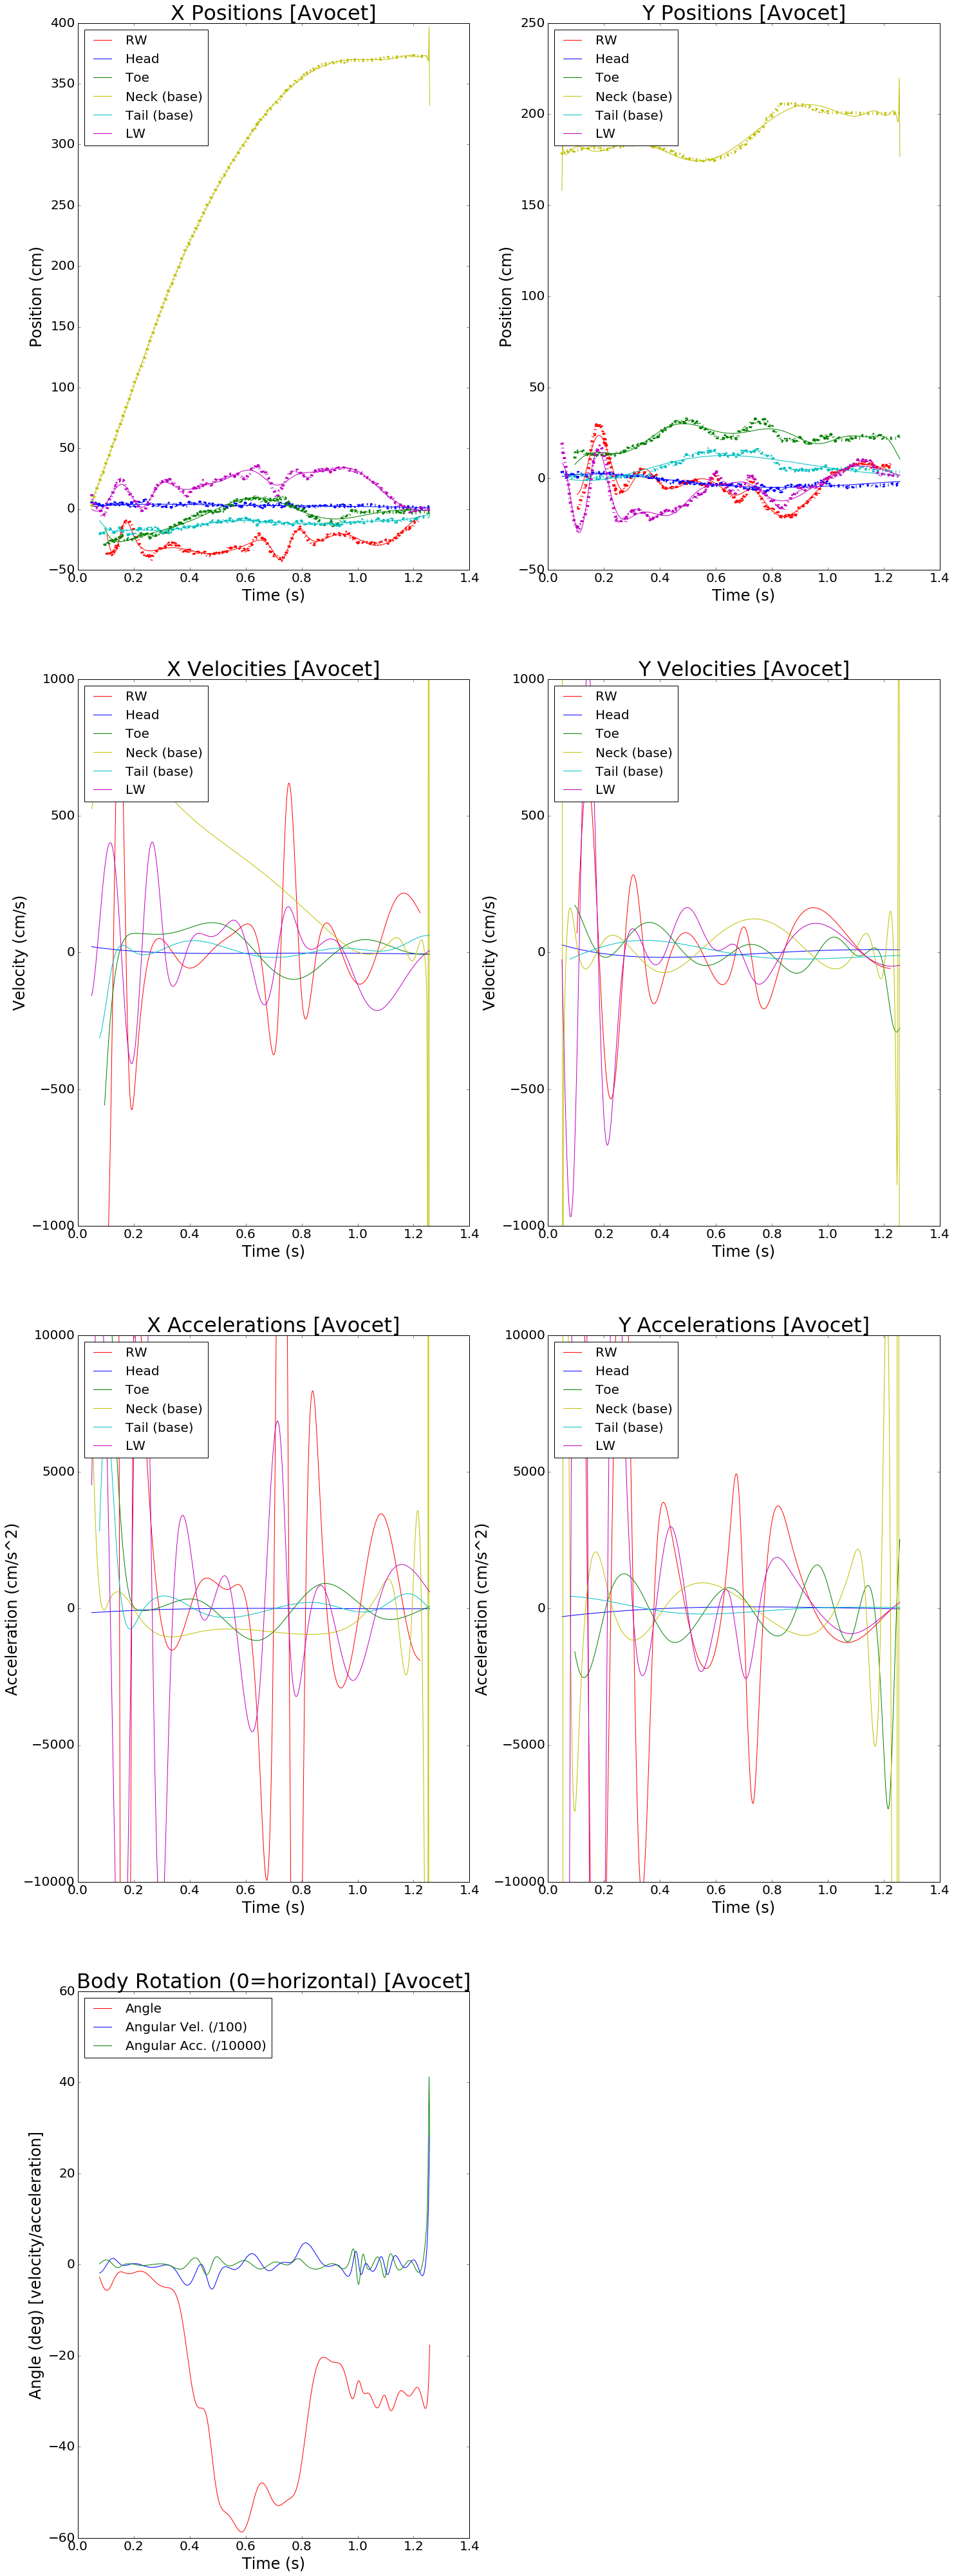

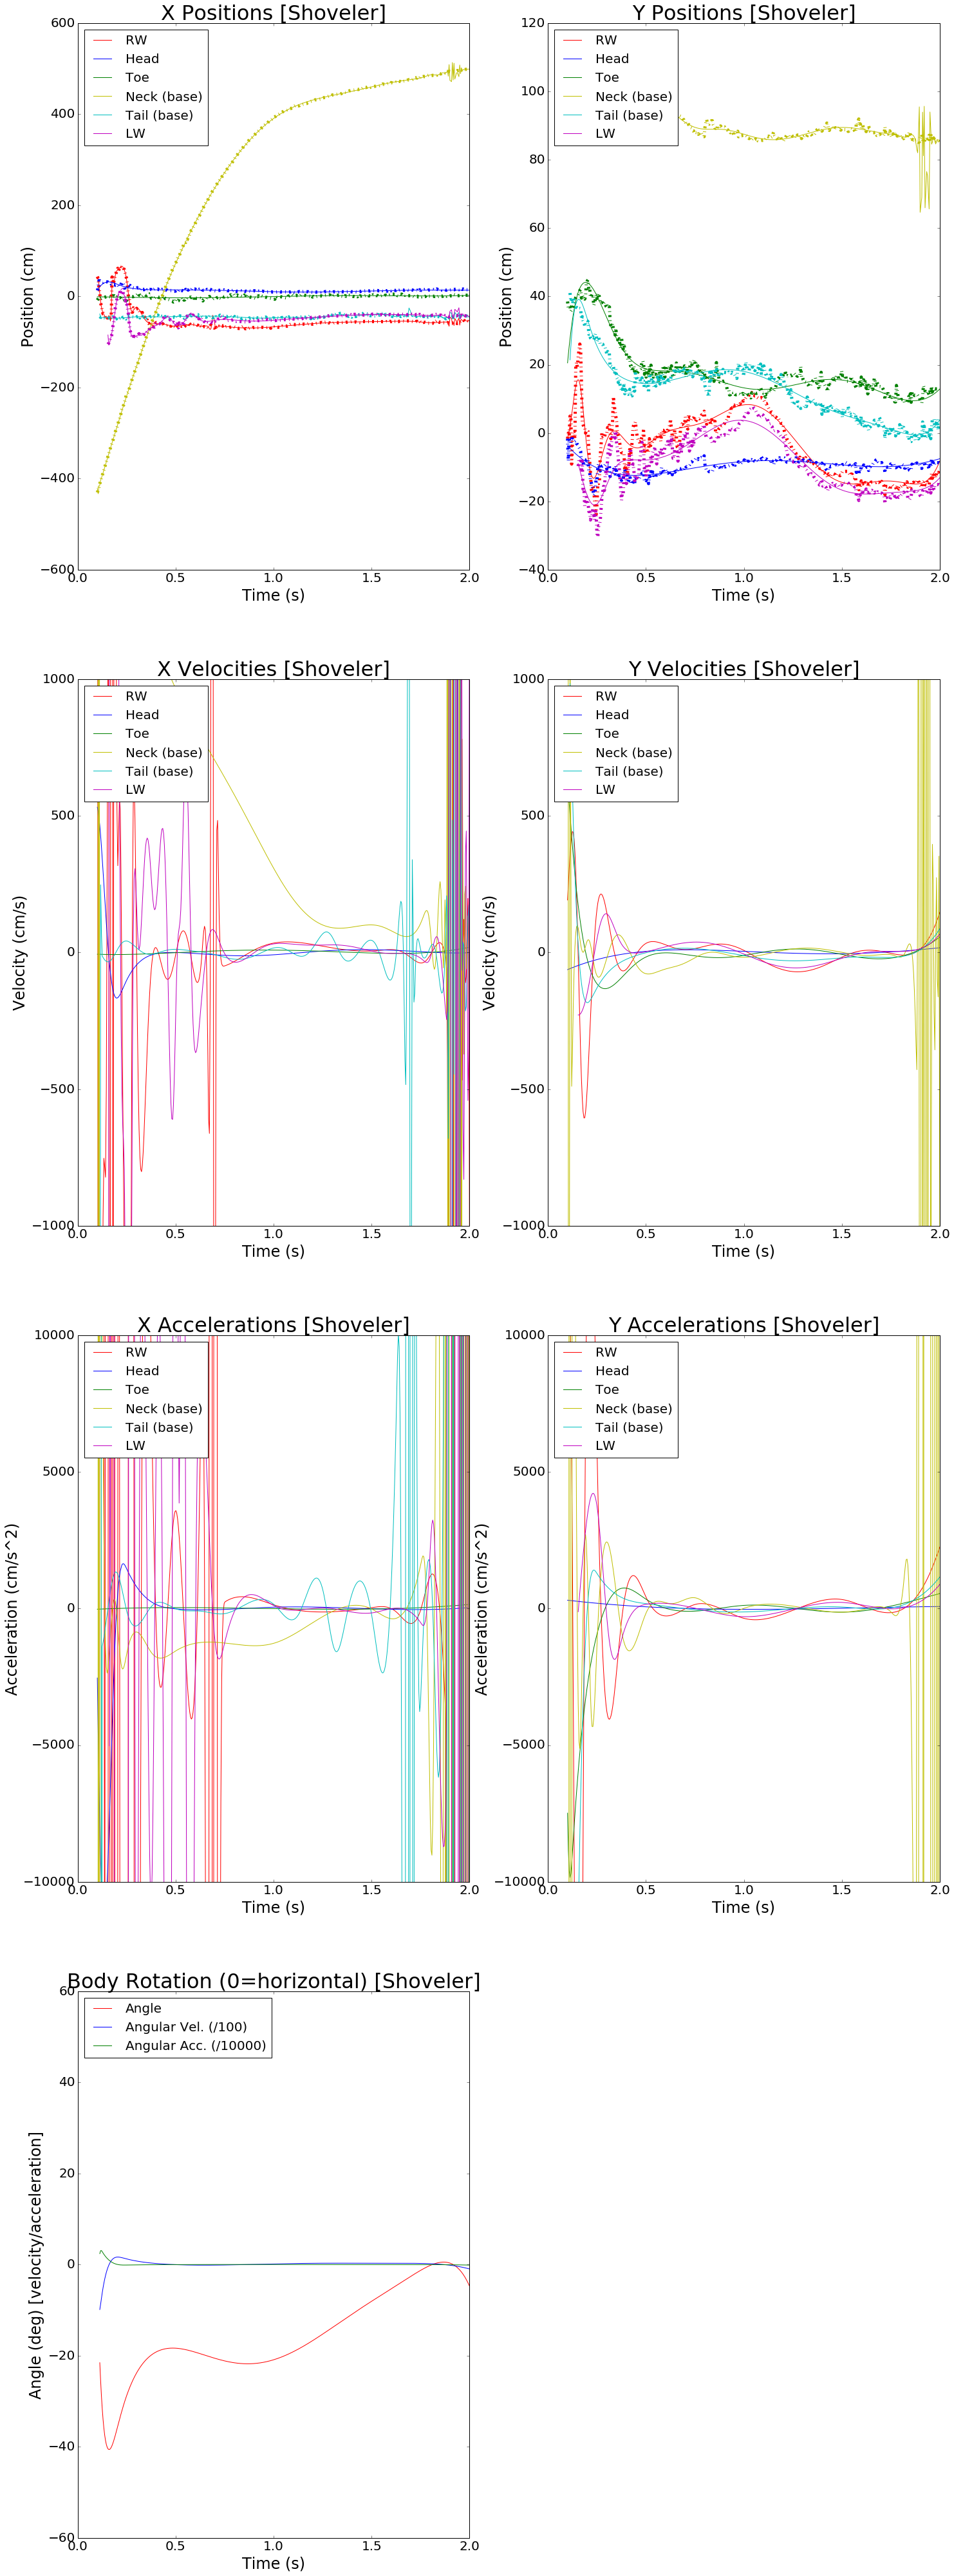

In [260]:
bird.disp_vel_acc()

Could see some TERRIBLE peaks even after smoothing up to s=100. They disappear when s is tweaked to >1000. Nevertheless, the smoothing should depend on the behavior of each curve and therefore should not be a constant overall.

---
### <font color="red">Todo (02/25/17)</font>
* Low-pass filter
* coordinate transformations / projection correction
*